# Rossby wave Model with 5 modes
## This jupyter notebook test inverse problem with swath samples

#### First we calculate the Brunt-Vaisla frequency squared with a sample dataset.

In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import VERT_FSFB3

In [2]:
pwd #ls

'/Users/yugao/Desktop/SWOT/SWOT_CER/AVISSO/AVISO_correlated_err_swath'

In [3]:
state_ds = xr.open_dataset('/Users/yugao/Desktop/SWOT/SWOT_CER/RossbyWaveTest/SWOT_state_2015-01-06.nc')

In [4]:
LAT, LON = state_ds.YC.data, state_ds.XC.data

In [5]:
lat, lon = np.meshgrid(LAT, LON)

# Read Temperature, Salinity and Pressure data

In [6]:
temp = state_ds.THETA
salinity = state_ds.SALT
Z = state_ds.Z
pres_anomalies  =  state_ds.PHIHYD

# Calculate Brunt-Vaisla frequency squared

In [7]:
SA, CT = np.ma.masked_all(salinity.shape), np.ma.masked_all(temp.shape)
Nsquared = np.ma.masked_all([salinity.shape[0]-1,salinity.shape[1], salinity.shape[2]])
Pressure_mid = np.ma.masked_all([salinity.shape[0]-1,salinity.shape[1], salinity.shape[2]])
pres = np.ma.masked_all([salinity.shape[0],salinity.shape[1], salinity.shape[2]])
Z_mid = np.ma.masked_all([salinity.shape[0]-1, salinity.shape[1], salinity.shape[2]])
for y in range(SA.shape[1]):
    for x in range(SA.shape[2]):
        pres[:, y, x] = gsw.p_from_z(Z.data,  lat = LAT[y]) #+ pres_anomalies.data[:, y, x]
        SA[:, y, x] = gsw.conversions.SA_from_SP(salinity.data[:, y, x], pres.data[:, y, x], LON[x], LAT[y])
        CT[:, y, x] = gsw.CT_from_pt(SA.data[:, y, x], temp.data[:, y, x])  
        Nsquared[:, y, x], Pressure_mid[:, y, x] = gsw.stability.Nsquared(SA[:, y, x], CT[:, y, x], pres[:, y, x])
        Z_mid[:, y, x] = gsw.z_from_p(Pressure_mid[:, y, x] , lat = LAT[y])

In [8]:
xlon, ylat = np.meshgrid(LON, LAT)

In [9]:
zz, yy = np.meshgrid(Z[1:], LAT)

### Choose a vector at a random location

In [10]:
laty, lonx = 130, 220

## Interpolate the N2 vector onto a uniform pressure grid

In [11]:
N2_vector = Nsquared[:, laty, lonx]
Pmid_vector = Pressure_mid[:, laty, lonx]
for i in range(len(N2_vector)-1):
    if N2_vector[i] < 0:
        N2_vector[i] = N2_vector[i+1] #np.median(np.absolute(N2_vector))
    if N2_vector[i] == 0:
        N2_vector[i] = N2_vector[i+1] #np.median(np.absolute(N2_vector))

In [12]:
Pmid_uniform = np.arange(Pmid_vector[0], Pmid_vector[-1], step = 120)
N2_uniform = np.interp(Pmid_uniform, Pmid_vector[:-2], N2_vector[:-2])

In [13]:
Pmid_uniform = Pmid_uniform[:]
N2_uniform = N2_uniform[:]

In [14]:
c2, Psi, G, N2, Pmid = VERT_FSFB3.VERT_FSFB3(N2_uniform[:-16], Pmid_uniform[:-16])

In [15]:
g = 9.81 # gravity

In [16]:
Z_mid_uniform  = gsw.z_from_p(np.append(0,Pmid), lat = laty)

In [17]:
MODE = G.shape[-1]

In [18]:
Zgrid, mode = np.meshgrid(Z_mid_uniform, range(MODE) )

### Beta plane paramters

In [19]:
Phi0 = 30 # central latitude (φ0)
Omega = 7.2921159e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 # meters
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N

### SSH - 4 waves, 5 baroclinic modes, 3 wavenumbers, 5 modes, 15 frequencies, 8 amplitudes

#### The dispersion relation relates frequency to wavenumber for each mode:

In [20]:
MModes = 2 # number of modes, determines wavespeed
# if MModes>1, each mode must have different wavelengths for the waves to separate in time
wavelength = np.array([2e6, 1e6, 5e5, 2e5]).reshape(2, MModes)
wavelength_l = np.array([7.5e5, 3.5e5, 1.5e5, .5e5]).reshape(2, MModes)
wavespeed = c2[:MModes] # Phase speed
k_n = 2 * np.pi / wavelength # X direction wavenumber
l_n = 2 * np.pi / wavelength_l # Y direction wavenumber
Rm = wavespeed[:MModes] / f0 # Rossby deformation radius
freq_n = np.zeros([len(wavelength), MModes])
for nn in range(len(k_n)):
    for mm in range(MModes):
        freq_n[nn, mm] = (Beta * k_n[nn, mm]) / (k_n[nn, mm] ** 2 + l_n[nn, mm] ** 2 + Rm[mm] ** (-2))
Amp = np.random.rand(2, MModes, len(wavelength)) #np.ones([2, MModes, len(wavelength)]) #
M = Amp.size

In [21]:
X_loc = np.arange(0, 1e6, .5e4) # domain size 1000 km with 10km resolution
Y_loc = np.arange(0, 1e6, .5e4)
T_time = np.arange(0, 5e8, .5e7) # Time step : ~57days

### H Matrix and SSH

In [22]:
%%time
H_cos = np.zeros([len(T_time), len(X_loc), len(Y_loc), MModes, len(wavelength)] ) # Number of waves * Number of data
H_sin = np.zeros([len(T_time), len(X_loc), len(Y_loc), MModes, len(wavelength)])
SSH_XYTMN = np.ma.masked_all([len(T_time), len(X_loc), len(Y_loc), MModes, len(wavelength)])
for tt in range(len(T_time)):
    for xx in range(len(X_loc)):
        for yy in range(len(Y_loc)):
            for mm in range(Amp.shape[1]): #Amp.shape[1]
                for nn in range(len(k_n)): #len(k_n)
                    H_cos[tt, xx, yy, mm, nn] = Psi[0, mm] * np.cos(k_n[nn, mm] * X_loc[xx] + l_n[nn, mm] * Y_loc[yy] + freq_n[nn, mm] * T_time[tt]) 
                    H_sin[tt, xx, yy, mm, nn] = Psi[0, mm] * np.sin(k_n[nn, mm] * X_loc[xx] + l_n[nn, mm] * Y_loc[yy] + freq_n[nn, mm] * T_time[tt])

for mm in range(MModes): #MModes
    for nn in range(len(k_n)): #len(k_n)
        SSH_XYTMN[:, :, :, mm, nn] = Amp[0, mm, nn] * H_cos[:, :, :, mm, nn] + Amp[1, mm, nn] * H_sin[:, :, :, mm, nn]

CPU times: user 41.1 s, sys: 206 ms, total: 41.3 s
Wall time: 41.4 s


#### Add up long the last two axis: modes, frequences

In [23]:
SSH_XYT = np.sum(SSH_XYTMN, axis = (-1, -2))

#### 2 SWOT swaths: two 50km swaths with 20 km gap in middle

In [24]:
a, b, c, d = 0, 1, 0, 1
x0 = np.arange(0, len(X_loc), 1)
y0 = np.arange(0, len(Y_loc), 1)
xswath_index0 = a +  b * x0
yswath_index0 = c +  d * y0
swath_ysize = 12
yswath_index_left = np.ma.masked_all([12, len(yswath_index0)])
xswath_index_left = np.ma.masked_all([12, len(xswath_index0)])
for yy in range(1, swath_ysize):
    if(yy!= 6&7):
        yswath_index_left[yy] = yswath_index0 + yy
        xswath_index_left[yy] = xswath_index0
yswath_index_left = np.ma.masked_outside(yswath_index_left, 0, len(Y_loc)-1)
xswath_index_left = np.ma.masked_outside(xswath_index_left, 0, len(X_loc)-1)
y_mask_left = np.ma.getmask(yswath_index_left)
x_mask_left  = np.ma.getmask(xswath_index_left)
xswath_index_left = np.ma.MaskedArray(xswath_index_left, y_mask_left)
yswath_index_left = np.ma.MaskedArray(yswath_index_left, x_mask_left)

In [25]:
a1, b1, c1, d1 = 0, 1., 190, -1.
x1 = np.arange(len(X_loc), 0, -1)
y1 = np.arange(len(Y_loc), 0, -1)
xswath_index1 = a1 +  b1 * x1
yswath_index1 = c1 +  d1 * y1
swath_ysize = 12
yswath_index_right = np.ma.masked_all([12, len(yswath_index1)])
xswath_index_right = np.ma.masked_all([12, len(xswath_index1)])
for yy in range(1, swath_ysize):
    if(yy!= 6&7):
        yswath_index_right[yy] = yswath_index1 + yy
        xswath_index_right[yy] = xswath_index1
yswath_index_right = np.ma.masked_outside(yswath_index_right, 0, len(Y_loc)-1)
xswath_index_right = np.ma.masked_outside(xswath_index_right, 0, len(X_loc)-1)
y_mask_right = np.ma.getmask(yswath_index_right)
x_mask_right = np.ma.getmask(xswath_index_right)
xswath_index_right = np.ma.MaskedArray(xswath_index_right, y_mask_right)
yswath_index_right = np.ma.MaskedArray(yswath_index_right, x_mask_right)

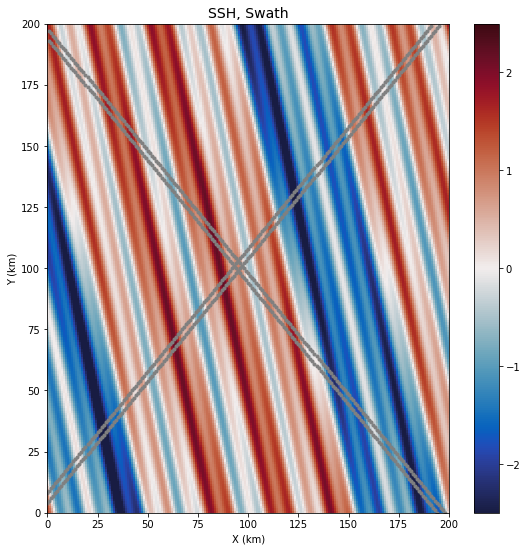

In [26]:
fig = plt.figure(figsize = (9, 9))
plt.pcolor( SSH_XYT[20], cmap = cmo.cm.balance, vmin = -2.5, vmax = 2.5)
plt.title('SSH, Swath', fontsize = 14)
for yy in range(0, swath_ysize, 4):
    plt.plot(xswath_index_right[yy], yswath_index_right[yy] , '.', color = 'gray')
for yy in range(0, swath_ysize, 4):
    plt.plot(xswath_index_left[yy], yswath_index_left[yy] , '.', color = 'gray')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
#plt.xticks(np.arange(0, 201, 20), np.arange(0, 2001, 200))
#plt.yticks(np.arange(0, 201, 20), np.arange(0, 2001, 200)) # Resolution 10 km
plt.colorbar()
plt.savefig('swath_sample.png')

#### Retrieve valid data and random sample in time 

In [27]:
# multiple-day swath
yvalid_index = np.append(yswath_index_left.compressed().astype(int), yswath_index_right.compressed().astype(int)) 
xvalid_index = np.append(xswath_index_left.compressed().astype(int), xswath_index_right.compressed().astype(int))
tindex = np.append(np.repeat(1, len(yvalid_index)), np.repeat(2, len(yvalid_index)),)

In [28]:
days = 2
yvalid_index = np.tile(yvalid_index, days)
xvalid_index = np.tile(xvalid_index, days)
N = len(yvalid_index)

In [29]:
#np.random.randint(low = 0, high= 99, size= xvalid_index.size)  # Random sampling in time# 
# Construct the (t, x, y) indice of the swath points
len(tindex) == N

True

In [30]:
H_ = np.ma.masked_all([len(T_time), len(X_loc), len(Y_loc), MModes*2, len(wavelength)]) # Number of data * Number of models
H_[:, :, :, 0::2] = H_cos #.reshape([len(T_time), len(X_loc), len(Y_loc), 15], order='F')
H_[:, :, :, 1::2] = H_sin #.reshape([len(T_time), len(X_loc), len(Y_loc), 15], order='F')

#### Add white noise to SSH 

In [31]:
num_samples = len(Y_loc)
noise_std = .1

In [32]:
# Add noise later
#SSH_WN = np.ma.masked_all(SSH_XYT.shape)
#white_noise_x, white_noise_y = np.ma.masked_all(SSH_XYT.shape), np.ma.masked_all(SSH_XYT.shape)
#for tt in range(len(T_time)):
#    for yy in range(len(X_loc)):
#        #white_noise_y[tt, yy] = np.random.normal(0, noise_std, size = num_samples)

SSH_WN = SSH_XYT #+ white_noise_y[tt, yy]

#### Weighted least square solution

#### R and P Matrix

In [33]:
RR, PP = 1, 1

In [34]:
R_ = np.eye(N, N)

In [35]:
P_ = np.eye(M, M)

In [36]:
for ii in range(N):
    R_[ii, ii] = RR #(residual * 0.7) ** 2 # (half of the variance is noise) 1e-6  # Uncertainty in data

for ii in range(M):    
    P_[ii, ii] = PP # Uncertainty in model

### Add simulated roll error

#### Create simulated roll error

#### Alpha varies in time

In [37]:
alpha_roll = 2e-1
alpha_base = 2e-2

In [38]:
# Roll error
roll_err_left = np.ma.masked_all(yswath_index_left.shape)
roll_err_right = np.ma.masked_all(yswath_index_right.shape)
# Baseline dilation error
baseline_dilation_err_left = np.ma.masked_all(yswath_index_left.shape)
baseline_dilation_err_right = np.ma.masked_all(yswath_index_right.shape)

#### swath 1 Error

In [39]:
xc1_left = np.ma.masked_all(yswath_index_left.shape)
xc2_left = np.ma.masked_all(yswath_index_left.shape)

ac, al = roll_err_left.shape

for xx in np.arange(ac):
    xc1_left[xx, :] = (xx - (ac-1)/2)       # * 1e4 10km resolution
    xc2_left[xx, :] = (xx - (ac-1)/2) ** 2   # * 1e4 10km resolution
    roll_err_left[xx, :] = alpha_roll * xc1_left[xx, :] 
    baseline_dilation_err_left[xx, :] = alpha_base * xc2_left[xx, :]

#### swath 2 Error

In [40]:
xc1_right = np.ma.masked_all(yswath_index_right.shape)
xc2_right = np.ma.masked_all(yswath_index_right.shape)

ac, al = roll_err_right.shape

for xx in np.arange(ac):
    xc1_right[xx, :] = (xx - (ac-1)/2)        # * 1e4 10km resolution
    xc2_right[xx, :] = (xx - (ac-1)/2) ** 2   # * 1e4 10km resolution
    roll_err_right[xx, :] = alpha_roll * xc1_right[xx, :]
    baseline_dilation_err_right[xx, :] = alpha_base * xc2_right[xx, :]

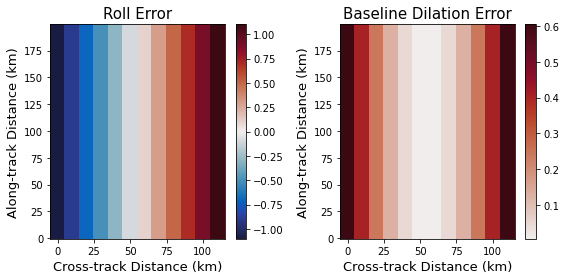

In [41]:
plt.figure(figsize = (8, 4))
plt.subplot(121)
plt.pcolor(np.arange(0, 120, 10), np.arange(len(X_loc)),roll_err_left.T, cmap = cmo.cm.balance)
plt.colorbar()
plt.ylabel('Along-track Distance (km)', fontsize = 13)
plt.xlabel('Cross-track Distance (km)', fontsize = 13)
plt.title('Roll Error', fontsize = 15)

plt.subplot(122)
plt.pcolor(np.arange(0, 120, 10), np.arange(len(X_loc)), baseline_dilation_err_left.T, cmap = cmo.cm.amp)
plt.colorbar()
plt.ylabel('Along-track Distance (km)', fontsize = 13)
plt.xlabel('Cross-track Distance (km)', fontsize = 13)
plt.title('Baseline Dilation Error', fontsize = 15)
plt.savefig('Cross_track_Correlated_Roll_Error.png', dpi = 100)

plt.tight_layout()
plt.savefig('Cross_track_Correlated_Roll_Error.png', dpi = 100)

In [42]:
roll_err_left_masked = np.ma.MaskedArray(roll_err_left, y_mask_left)
roll_err_right_masked = np.ma.MaskedArray(roll_err_right, y_mask_right)
baseline_dilation_err_left_masked = np.ma.MaskedArray(baseline_dilation_err_left, y_mask_left)
baseline_dilation_err_right_masked = np.ma.MaskedArray(baseline_dilation_err_right, y_mask_right)
xc1_left_masked = np.ma.MaskedArray(xc1_left, y_mask_left)
xc2_left_masked = np.ma.MaskedArray(xc2_left, y_mask_left)
xc1_right_masked = np.ma.MaskedArray(xc1_right, y_mask_right)
xc2_right_masked = np.ma.MaskedArray(xc2_right, y_mask_right)

In [43]:
%%time
roll_err_left_valid = roll_err_left_masked.compressed() # retrieve the valid data 
roll_err_right_valid = roll_err_right_masked.compressed() # retrieve the valid data 
baseline_dilation_err_left_valid = baseline_dilation_err_left_masked.compressed() # retrieve the valid data 
baseline_dilation_err_right_valid = baseline_dilation_err_right_masked.compressed() # retrieve the valid data 
xc1_left_valid = xc1_left_masked.compressed() # retrieve the valid data 
xc2_left_valid = xc2_left_masked.compressed() # retrieve the valid data 
xc1_right_valid = xc1_right_masked.compressed() # retrieve the valid data 
xc2_right_valid = xc2_right_masked.compressed() # retrieve the valid data 

CPU times: user 961 µs, sys: 1.35 ms, total: 2.31 ms
Wall time: 800 µs


In [44]:
roll_err_valid_index = np.append(roll_err_left_valid, roll_err_right_valid) 
baseline_dilation_err_index = np.append(baseline_dilation_err_left_valid, baseline_dilation_err_right_valid) 
xc1_index = np.append(xc1_left_valid, xc1_right_valid)
xc2_index = np.append(xc2_left_valid, xc2_right_valid)

#### repeat roll error and baseline dilation error for multiple days

In [45]:
roll_err1_valid = np.tile(roll_err_valid_index, days) # repeat the roll error "days" times
baseline_dilation_err_valid = np.tile(baseline_dilation_err_index, days) # repeat the baseline dilation error "days" times
xc1_valid = np.tile(xc1_index, days)
xc2_valid = np.tile(xc2_index, days)

In [46]:
#baseline_dilation_err_valid

#### Add roll error to SSH

### Two-step approach: reconstructing the SSH separately from solving the correlated error

#### First step: fit errors

In [47]:
# Convert the T, X, Y space to 1-dimensional space
IIndex = np.zeros(N) # N: Number of y data
Y_v = np.zeros(N) 
H_v1 = np.zeros([N,  2]) # M: number of model
nx, ny = N, N
Y_v, cor_err, ssh = np.zeros(N), np.zeros(N), np.zeros(N)
for iii in range(N):
    ssh[iii] = SSH_WN[tindex[iii], xvalid_index[iii], yvalid_index[iii]]
    cor_err[iii] = roll_err1_valid[iii] #+ baseline_dilation_err_valid[iii])
    Y_v[iii] =   cor_err[iii] + SSH_WN[tindex[iii], xvalid_index[iii], yvalid_index[iii]]
    H_v1[iii, -1] = xc1_valid[iii] #/ xc1_valid.max() # ROLL ERR, distance from nadir Xc !!! Normalized
    H_v1[iii, -2] = xc2_valid[iii] #/ xc2_valid.max() # BASELINE DIALATION ERR, distance from nadir Xc !!! Normalized

In [48]:
P_over_R1 = np.eye(2, 2)
P_over_R1[-1, -1] = (alpha_roll) ** 2/RR # roll
P_over_R1[-2, -2] = (alpha_base) ** 2/RR # base

In [49]:
HTH = np.matmul(H_v1.T, H_v1)

In [50]:
HRH = HTH + P_over_R1 #0.81 * sigma #, P: uncertainty in model, R: uncertainty in data
D = np.matmul(LA.inv(HRH), H_v1.T)   

In [51]:
P_over_R1, RR

(array([[0.0004, 0.    ],
        [0.    , 0.04  ]]),
 1)

In [52]:
amp_err = np.matmul(D, Y_v) # ssh + err
amp_err , alpha_base,  alpha_roll, ## only correlated error !!! 

(array([-5.80507644e-05,  1.94921861e-01]), 0.02, 0.2)

#### correlated error

In [53]:
#### estimate the correlated error
err_est = np.matmul(H_v1, amp_err)

In [54]:
err_map = np.zeros(SSH_WN.shape)
for ii, idx in enumerate(xvalid_index):
    err_map[tindex[ii],  xvalid_index[ii], yvalid_index[ii]] = err_est[ii]

In [55]:
#

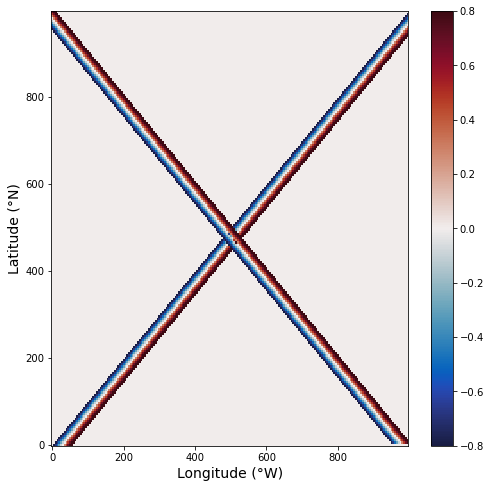

In [56]:
plt.figure(figsize = (8, 8))
plt.pcolormesh(X_loc/1e3, Y_loc/1e3, err_map[1], cmap = cmo.cm.balance, vmin = -0.8, vmax = 0.8)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.savefig('idealized_err_map.png', dpi = 300)

In [57]:
err_map.shape

(100, 200, 200)

#### SSH + correlated errors - estimated correlated errors

In [58]:
tau_ssh = Y_v - err_est

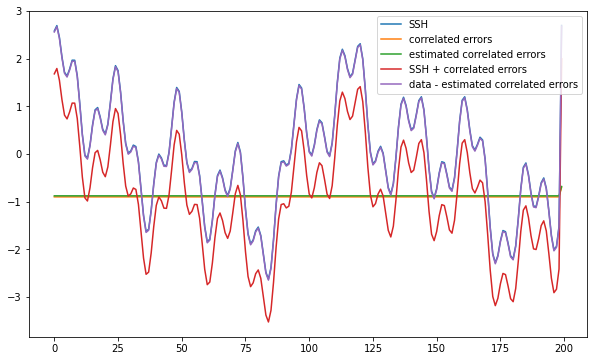

In [59]:
plt.figure(figsize = (10, 6))
plt.plot(ssh[:200], label = 'SSH')
plt.plot(cor_err[:200], label = 'correlated errors')
plt.plot(err_est[:200], label = 'estimated correlated errors')
plt.plot(Y_v[:200], label = 'SSH + correlated errors')
plt.plot(tau_ssh[:200], label = 'data - estimated correlated errors')
#plt.plot(Y_hat_1st_step, label = 'estimated SSH + correlated errors')
plt.legend()

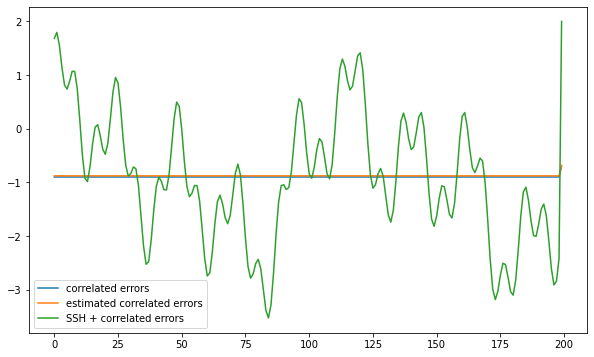

In [60]:
plt.figure(figsize = (10, 6))
#plt.plot(ssh[:200], label = 'SSH')
plt.plot(cor_err[:200], label = 'correlated errors')
plt.plot(err_est[:200], label = 'estimated correlated errors')
plt.plot(Y_v[:200], label = 'SSH + correlated errors')
#plt.plot(tau_ssh[:200], label = 'data - estimated correlated errors')
#plt.plot(Y_hat_1st_step, label = 'estimated SSH + correlated errors')
plt.legend()

#### second step: fit residual to rossby wave models

In [61]:
count = 0
MSLA_swath = np.zeros(len(xvalid_index))
nx, ny = len(lon), len(lat)
H_v2 = np.zeros([N, M ]) # M: number of model
IIndex = np.zeros(N) # N: Number of y data
Y_v = np.zeros(N)
for iii in range(len(xvalid_index)):
    for mm in range(MModes):
        for nn in range(len(wavelength)):
            H_IIndex = nx * ny * tindex[iii] + ny * xvalid_index[iii] + yvalid_index[iii] ## Data space
            JIndex = 2 * MModes * nn +  2 * mm  # Model space
            H_v2[iii, JIndex] = H_cos[tindex[iii], xvalid_index[iii], yvalid_index[iii], mm, nn]
            H_v2[iii, JIndex + 1] = H_sin[tindex[iii], xvalid_index[iii], yvalid_index[iii], mm, nn]

In [62]:
HTH = np.matmul(H_v2.T, H_v2)

In [63]:
R_ = np.eye(N, N)
P_over_R = np.eye( M, M)
for ii in range(N):
    R_[ii, ii] = RR #(residual * 0.7) ** 2 # (half of the variance is noise) 1e-6  # Uncertainty in data
    
for ii in range( M):    
    P_over_R[ii, ii] = PP/RR # Uncertainty in model

In [64]:
HRH = np.zeros(HTH.shape)
HRH = HTH +  P_over_R #0.81 * sigma #, P: uncertainty in model, R: uncertainty in data

In [65]:
D = np.matmul(LA.inv(HRH), H_v2.T)
eig, vec = LA.eig(HRH)

#### Soution with noise

In [66]:
amp_swath = np.matmul(D, tau_ssh)

In [67]:
amp_swath_with_err = np.append(amp_swath, amp_err )
true_amp = np.append(Amp.reshape(2* MModes* len(wavelength), order = 'F'), [alpha_base, alpha_roll])

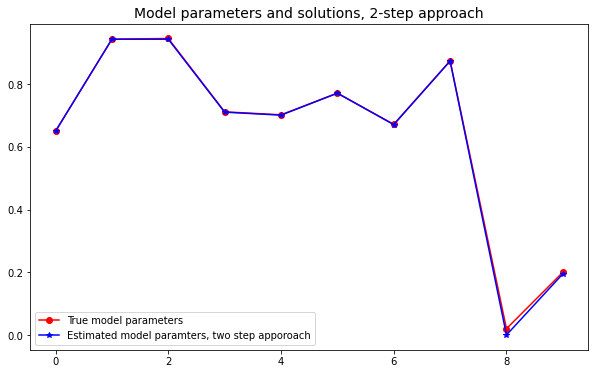

In [68]:
plt.figure(figsize = (10, 6))
plt.plot(true_amp, 'o-', color = 'red',  label = 'True model parameters')
plt.plot(amp_swath_with_err,'*-', color = 'blue', label = 'Estimated model paramters, two step apporoach')
#plt.plot(amp_w_err,  'x-', color = 'orange' , label = 'Estimated model paramters, one-step approach') # yerr = STD, fmt = 'o',color = 'orange', ecolor = 'lightgreen', elinewidth = 2, capsize=10
plt.legend()
plt.title('Model parameters and solutions, 2-step approach', fontsize = 14)
plt.savefig('idealized_amp_2step.png')
## add error bar to amplitude solution 
## err bar is standard deviation of diff betweeen estimated and true model paramters, eq. 8

In [69]:
%%time
SSH_XYTMN_reconstruct = np.ma.masked_all([len(T_time), len(X_loc), len(Y_loc), MModes, len(wavelength)])
Amp_solution = amp_swath[:].reshape(2, MModes, len(wavelength), order = 'F')
for mm in range(MModes):
    for nn in range(len(k_n)):
        SSH_XYTMN_reconstruct[:, :, :, mm, nn] = Amp_solution[0, mm, nn] * H_cos[:, :, :, mm, nn] + Amp_solution[1, mm, nn] * H_sin[:, :, :, mm, nn]

CPU times: user 91.7 ms, sys: 61.2 ms, total: 153 ms
Wall time: 87.4 ms


In [70]:
SSH_XYT_reconstruct = SSH_XYTMN_reconstruct.sum(axis = (-1, -2))

In [71]:
SSH_XYTMN_reconstruct[tt].shape

(200, 200, 2, 2)

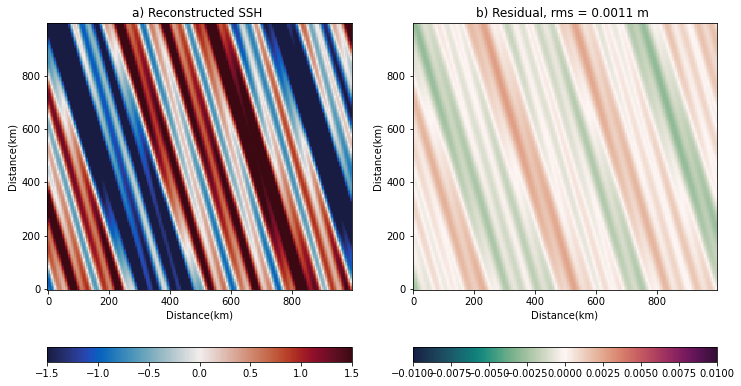

In [72]:
plt.figure(figsize = (12, 7))

plt.subplot(121)
plt.pcolor(X_loc/1e3, Y_loc/1e3, SSH_XYT_reconstruct[tt], cmap = cmo.cm.balance, vmin = -1.5, vmax = 1.5) #, vmin = -2.5, vmax = 2.5
plt.xlabel('Distance(km)')
plt.ylabel('Distance(km)')
plt.title('a) Reconstructed SSH ')
plt.colorbar(orientation = 'horizontal')

DIFF = SSH_XYT_reconstruct[:] - SSH_WN[:]
plt.subplot(122)
plt.pcolor(X_loc/1e3, Y_loc/1e3, SSH_WN[tt] - SSH_XYT_reconstruct[tt], cmap = cmo.cm.curl, vmin = -.01, vmax = .01) #], vmin = -.05, vmax = .05,
plt.xlabel('Distance(km)')
plt.ylabel('Distance(km)')
plt.title('b) Residual, rms = ' + str(np.sqrt(np.mean(DIFF**2)))[:6] + ' m ')
plt.colorbar(orientation = 'horizontal')
plt.savefig('Reconstrcuted_SSH_Residual_2step.png')

In [73]:
amp_swath_with_err[-2:], H_v1[:, -2:].shape

(array([-5.80507644e-05,  1.94921861e-01]), (7792, 2))

In [74]:
err_est = np.matmul(H_v1, amp_swath_with_err[-2:])
ssh_est = np.matmul(H_v2, amp_swath_with_err[:-2])

In [75]:
err_map = np.zeros(SSH_WN[0].shape)
ssh_map = np.zeros(SSH_WN[0].shape)
ssh_true = np.zeros(SSH_WN[0].shape)
err_true = np.zeros(SSH_WN[0].shape)
for ii, idx in enumerate(xvalid_index):
    err_map[xvalid_index[ii], yvalid_index[ii]] = err_est[ii] 
    ssh_map[xvalid_index[ii], yvalid_index[ii]]  = ssh_est[ii]
    err_true[xvalid_index[ii], yvalid_index[ii]] = cor_err[ii]
    ssh_true[xvalid_index[ii], yvalid_index[ii]] = ssh[ii]

In [76]:
ssh_diff = np.sqrt(np.mean((ssh_true - ssh_map) ** 2 ))/ np.sqrt(np.mean((ssh_true) ** 2 ))

In [77]:
ssh_diff*100

0.10328964676259

In [78]:
lon, lat = X_loc/1e3, Y_loc/1e3

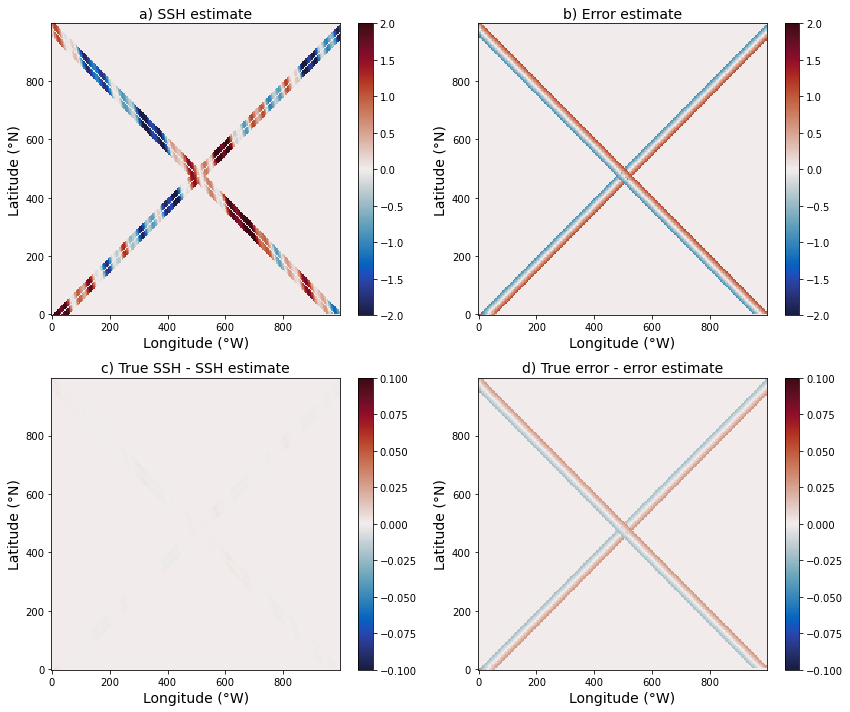

In [79]:
fig = plt.figure(figsize = (12, 10))

plt.subplot(221)
plt.pcolormesh(lon, lat, ssh_map, vmin = -2, vmax = 2, cmap = cmo.cm.balance)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('a) SSH estimate', fontsize = 14)

plt.subplot(222)
plt.pcolormesh(lon, lat, err_map, cmap = cmo.cm.balance, vmin = -2, vmax = 2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('b) Error estimate', fontsize = 14)

plt.subplot(223)
plt.pcolormesh(lon, lat, ssh_true - ssh_map, cmap = cmo.cm.balance, vmin = -.1, vmax = .1)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('c) True SSH - SSH estimate', fontsize = 14)

plt.subplot(224)
plt.pcolormesh(lon, lat, err_true - err_map, cmap = cmo.cm.balance, vmin = -.1, vmax = .1)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('d) True error - error estimate', fontsize = 14)

plt.tight_layout()
plt.savefig('idealized_err_map_2step.png')